In [2]:
import os
from utils import (
    create_client,
    create_schema,
    create_collection,
    load_images,
    create_index,
    search_by_text,
    draw_images,
)
import time
import matplotlib.pyplot as plt
from pymilvus import MilvusClient, db, connections
from clip_embeddings_generator import ClipEmbeddingsGenerator

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [3]:
connections.connect(host="milvus-standalone", port="19530")
if "avatares" not in db.list_database():
    db.create_database("avatares")
db.using_database("avatares")

Índices que vamos a testear:

### 1. IVF_FLAT (Inverted File System with Flat Search)
Es una variante del índice de cuantización vectorial que primero divide el espacio del vector en regiones utilizando un algoritmo de clustering como K-means. Cada vector se asigna al clúster más cercano y se almacena su representación exacta. Durante la búsqueda, sólo se explora el clúster (o los clústeres) más cercano al vector de consulta, reduciendo significativamente el número de comparaciones necesarias.

**Parámetros**:

- `nlist`: Especifica el número de clústeres a utilizar. Un valor más alto puede mejorar la precisión de la búsqueda a costa de utilizar más memoria y aumentar el tiempo de indexación.

### 2. HNSW (Hierarchical Navigable Small World)

Construye un grafo de múltiples capas donde cada capa es un grafo "de mundo pequeño". La capa superior tiene menos nodos y sirve como entrada rápida a las capas inferiores que contienen más nodos. Durante la inserción, cada nuevo vector se conecta a los nodos existentes de manera que se mantenga la propiedad del mundo pequeño, asegurando que cualquier nodo pueda ser alcanzado desde cualquier otro en un pequeño número de saltos. Para la búsqueda, se navega desde la capa superior hacia la inferior, aprovechando estos atajos para encontrar rápidamente los vecinos más cercanos del vector de consulta.

**Parámetros**:

- `M`: Controla el número de conexiones de borde que cada nodo tiene en el grafo. Un valor más alto puede mejorar la precisión pero aumenta el uso de memoria.
- `efConstruction`: Controla el tamaño de la cola dinámica usada durante la construcción del índice, afectando la calidad del grafo. Un valor más alto puede mejorar la precisión pero aumenta el tiempo de construcción del índice.

### 3. Métricas de Distancia
- `L2` (Distancia euclídea): Calcula la distancia geométrica tradicional entre dos puntos. Es efectiva cuando la magnitud de los vectores es importante.
- `IP` (Inner Product): Calcula la similitud como el producto punto de dos vectores, lo cual es útil para medir similitud en términos de ángulo, independientemente de la magnitud.
- `COSINE` (similaridad coseno): como el producto escalar pero normalizado. Es la métrica con la que se ha entrenado CLIP.


In [4]:
# Crear cliente y esquema
client: MilvusClient = create_client()
schema = create_schema()

# Inicializar el generador de embeddings
embedder = ClipEmbeddingsGenerator()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
image_dir = "images/"
image_paths = [
    os.path.join(image_dir, img)
    for img in os.listdir(image_dir)
    if img.endswith(".png")
]

In [6]:
def run_experiment(index_configs, search_params_list, n_searchs=200):
    """Crea y carga imágenes en diferentes colecciones para cada configuración de índice"""
    for i, (config, search_params) in enumerate(zip(index_configs, search_params_list)):
        collection_name = f"avatar_{config['index_type']}_{config['metric_type']}_{i}"
        create_collection(client, schema, collection_name)
        load_images(embedder, client, collection_name)

        start_time = time.perf_counter()
        create_index(client, collection_name, config=config)
        client.load_collection(collection_name=collection_name)
        elapsed_time_load = time.perf_counter() - start_time
        print(
            f"Collection: '{collection_name}', config = {config['params']}, {search_params = }"
        )
        print(f"Time to load: {elapsed_time_load}")

        text_query = "An old cat"
        min_elapsed_time = float("inf")
        for _ in range(n_searchs):
            start_time = time.perf_counter()
            search_results = search_by_text(
                client,
                collection_name,
                embedder,
                text_query,
                search_params=search_params,
            )
            elapsed_time = time.perf_counter() - start_time
            min_elapsed_time = min(min_elapsed_time, elapsed_time)

        print(f"Time to search {min_elapsed_time} | min of {n_searchs} runs")
        result_ids = [result["id"] for result in search_results[0]]
        image_paths_result = [image_paths[result_id] for result_id in result_ids]
        result_titles = [
            f"{result['id']} - dist: {result['distance']:.2f}"
            for result in search_results[0]
        ]

        draw_images(image_paths_result, result_titles)
        plt.show()

        # Liberar la colección después de la prueba
        client.release_collection(collection_name)

En este experimento, hemos evaluado diferentes configuraciones de índices y métricas de distancia para determinar cuál proporciona los mejores resultados de búsqueda en términos de tiempo y precisión. Los índices probados incluyen `FLAT`, `IVF_FLAT`, y `HNSW`, y las métricas de distancia utilizadas fueron `COSINE`, `L2`, e `IP`.

### Metodología

Usamos como
métrica la similaridad coseno ya que es la métrica con la que se entrenó CLIP.
Los resultados con los índices `FLAT` (comprobar todos los embeddings) parecen
corroborar esto. Si bien todos consiguen mostrar la imágen del gato en el top 5,
utilizando el resto de métricas aparece una mujer joven, la cual no se corresponde
con el adjetivo de "old" utilizado en la búsqueda.

Además, hemos utilizado el tiempo mínimo de las 200 ejecuciones de búsqueda en lugar de la suma total o la media para evitar que los outliers (valores atípicos) afecten los resultados. Los outliers pueden surgir debido a variaciones temporales en el rendimiento del sistema o interferencias de otros procesos en ejecución. Al tomar el tiempo mínimo, nos aseguramos de que nuestras mediciones reflejen el mejor rendimiento posible del sistema en condiciones óptimas, proporcionando una evaluación más precisa de la eficiencia de cada índice.

### Resultados

Por otro lado, aunque se esperaba que el índice `IVF_FLAT` redujera significativamente el tiempo de búsqueda, los resultados muestran que los tiempos de búsqueda son similares o incluso superiores a los del índice `FLAT`. Esto es atribuible al pequeño tamaño de nuestro conjunto de datos (229 imágenes), donde el beneficio de la reducción de comparaciones no compensa el overhead de la creación y navegación de los clústeres.

El índice `HNSW` también mostró buenos resultados, con tiempos de búsqueda y carga comparables a los de FLAT. Este índice es especialmente útil para grandes volúmenes de datos, aunque en nuestro caso, con un conjunto de datos pequeño, no mostró una ventaja significativa en términos de tiempo.

### Conclusiones

En general, los resultados sugieren que el índice `FLAT` con la métrica `COSINE` es la mejor configuración para nuestro conjunto de datos y tarea de búsqueda. Proporciona tiempos de búsqueda rápidos y con precisón óptima, sin el overhead adicional de la creación de clústeres o la navegación de grafos. Sin embargo, es importante tener en cuenta que estos resultados se deben principalmente al tamaño pequeño de nuestro conjunto de datos y pueden no generalizarse a conjuntos de datos más grandes.

Collection: 'avatar_FLAT_COSINE_0', config = {'index_type': 'FLAT', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'nprobe': 1}}
Time to load: 3.5721923130004143
Time to search 0.014744525000423891 | min of 200 runs


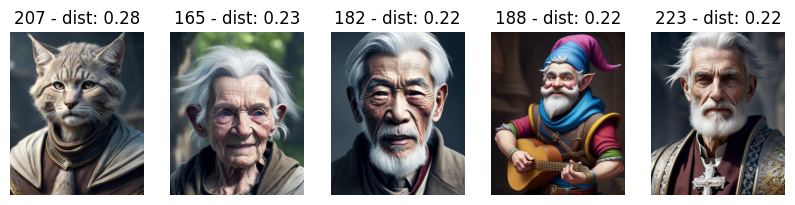

Collection: 'avatar_FLAT_L2_1', config = {'index_type': 'FLAT', 'metric_type': 'L2'}, search_params = {'metric_type': 'L2', 'params': {'nprobe': 1}}
Time to load: 3.056639307000296
Time to search 0.014502788999379845 | min of 200 runs


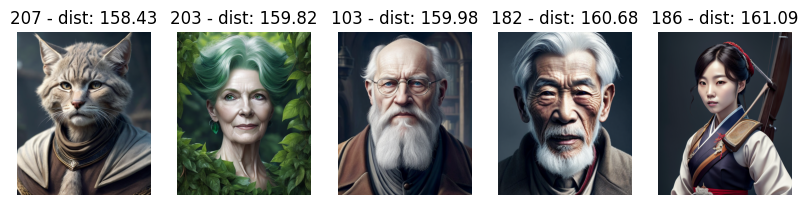

Collection: 'avatar_FLAT_IP_2', config = {'index_type': 'FLAT', 'metric_type': 'IP'}, search_params = {'metric_type': 'IP', 'params': {'nprobe': 1}}
Time to load: 3.5572382530008326
Time to search 0.013557439000578597 | min of 200 runs


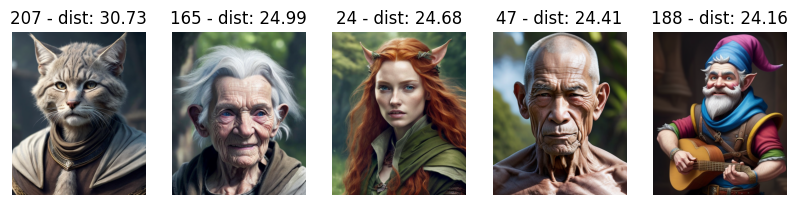

In [7]:
flat_index_configs = [
    {"index_type": "FLAT", "metric_type": "COSINE", "params": {}},
    {"index_type": "FLAT", "metric_type": "L2", "params": {}},
    {"index_type": "FLAT", "metric_type": "IP", "params": {}},
]
flat_search_params = [
    {"metric_type": "COSINE", "params": {"nprobe": 1}},
    {"metric_type": "L2", "params": {"nprobe": 1}},
    {"metric_type": "IP", "params": {"nprobe": 1}},
]
run_experiment(flat_index_configs, flat_search_params)

Collection: 'avatar_IVF_FLAT_COSINE_0', config = {'nlist': 4, 'index_type': 'IVF_FLAT', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'nprobe': 1}}
Time to load: 3.5822431549986504
Time to search 0.014989412000431912 | min of 200 runs


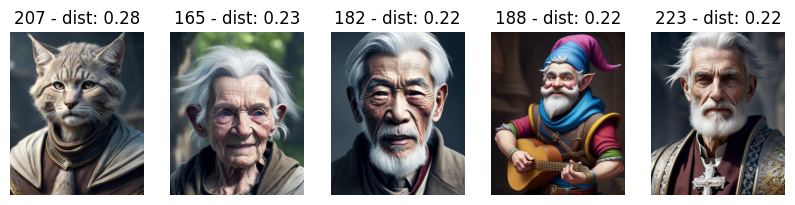

Collection: 'avatar_IVF_FLAT_COSINE_1', config = {'nlist': 4, 'index_type': 'IVF_FLAT', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'nprobe': 3}}
Time to load: 3.0589163879994885
Time to search 0.020164902998658363 | min of 200 runs


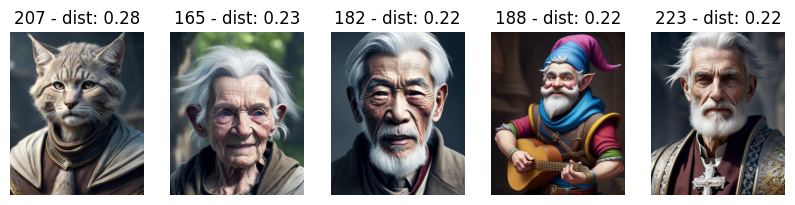

Collection: 'avatar_IVF_FLAT_COSINE_2', config = {'nlist': 8, 'index_type': 'IVF_FLAT', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'nprobe': 2}}
Time to load: 3.0622145120014466
Time to search 0.015960062999511138 | min of 200 runs


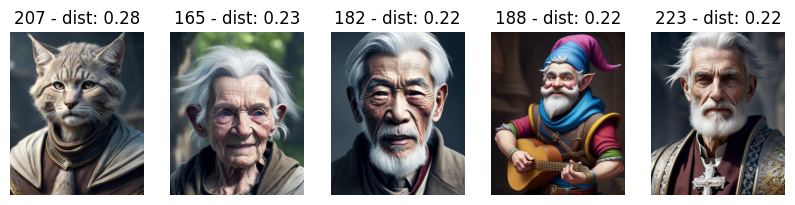

Collection: 'avatar_IVF_FLAT_COSINE_3', config = {'nlist': 16, 'index_type': 'IVF_FLAT', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'nprobe': 3}}
Time to load: 3.5578153599999496
Time to search 0.015575402001559269 | min of 200 runs


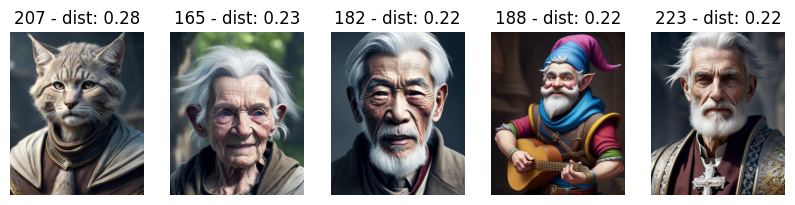

Collection: 'avatar_IVF_FLAT_COSINE_4', config = {'nlist': 32, 'index_type': 'IVF_FLAT', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'nprobe': 3}}
Time to load: 3.5718301739998424
Time to search 0.01601842699892586 | min of 200 runs


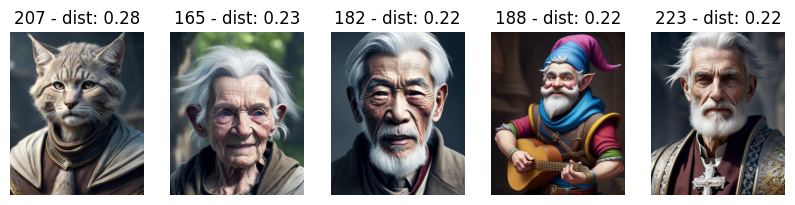

In [8]:
ivf_flat_configs = [
    {"index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nlist": 4}},
    {"index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nlist": 4}},
    {"index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nlist": 8}},
    {"index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nlist": 16}},
    {"index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nlist": 32}},
]
ivf_flat_search_params = [
    {"metric_type": "COSINE", "params": {"nprobe": 1}},
    {"metric_type": "COSINE", "params": {"nprobe": 3}},
    {"metric_type": "COSINE", "params": {"nprobe": 2}},
    {"metric_type": "COSINE", "params": {"nprobe": 3}},
    {"metric_type": "COSINE", "params": {"nprobe": 3}},
    {"metric_type": "COSINE", "params": {"nprobe": 3}},
]
run_experiment(ivf_flat_configs, ivf_flat_search_params)

Collection: 'avatar_HNSW_COSINE_0', config = {'M': 2, 'efConstruction': 500, 'index_type': 'HNSW', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'ef': 200}}
Time to load: 3.0566490510009316
Time to search 0.014856969999527792 | min of 200 runs


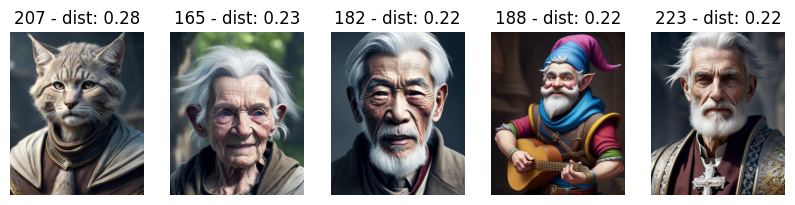

Collection: 'avatar_HNSW_COSINE_1', config = {'M': 4, 'efConstruction': 500, 'index_type': 'HNSW', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'ef': 200}}
Time to load: 3.580150642999797
Time to search 0.015511845000219182 | min of 200 runs


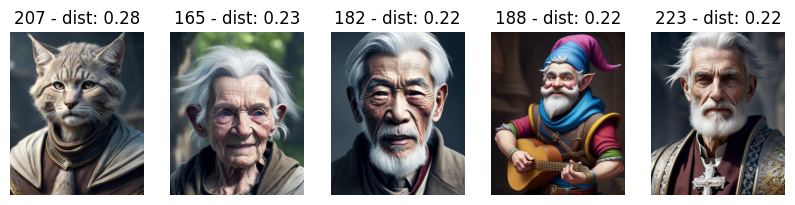

Collection: 'avatar_HNSW_COSINE_2', config = {'M': 8, 'efConstruction': 500, 'index_type': 'HNSW', 'metric_type': 'COSINE'}, search_params = {'metric_type': 'COSINE', 'params': {'ef': 200}}
Time to load: 3.5964231660000223
Time to search 0.014992626000093878 | min of 200 runs


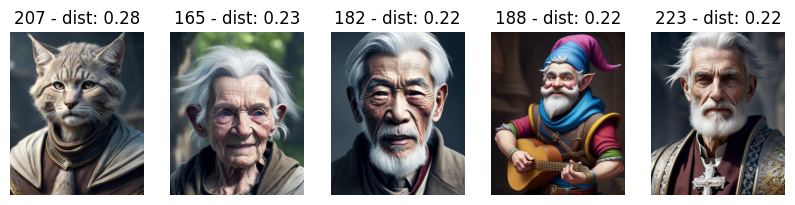

In [9]:
hsnw_configs = [
    {
        "index_type": "HNSW",
        "metric_type": "COSINE",
        "params": {"M": 2, "efConstruction": 500},
    },
    {
        "index_type": "HNSW",
        "metric_type": "COSINE",
        "params": {"M": 4, "efConstruction": 500},
    },
    {
        "index_type": "HNSW",
        "metric_type": "COSINE",
        "params": {"M": 8, "efConstruction": 500},
    },
]
hsnw_search_params = [
    {"metric_type": "COSINE", "params": {"ef": 200}},
    {"metric_type": "COSINE", "params": {"ef": 200}},
    {"metric_type": "COSINE", "params": {"ef": 200}},
]
run_experiment(hsnw_configs, hsnw_search_params)